## Comparing a hyperparameter tuned PINN with the analytical and numerical methods for solving the Linear Convection Diffusion equation

PDE $ \frac{\partial u}{\partial t} + c*u_x - v*u_{xx} = 0 $ with c = v = 1<br>
Domain: $ x \in [-1,1] $ and $ t \in (0,1] $<br>
Initial Condition: $ u(0,x) = - \sin(\pi x) $<br>
Boundary Condition: $ u(t,-1) = u(t,1) = 0 $<br>

In [ ]:
# importing libraries
import numpy as np
import scipy.integrate
from numpy import exp
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt
import tensorflow as tf
import math as m

In [ ]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
pi = tf.constant(m.pi, dtype=DTYPE)

In [ ]:
def u_init(x): # calculates u value at initial data points
  return -tf.sin(pi * x)

def u_bound(t, x): # calculates u value at boundary data points
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

In [ ]:
# Training Data

Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points
ui = u_init(xi) # Evaluate Initial Condition

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin = tf.keras.backend.random_bernoulli((Nb,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb = xmin + (xmax - xmin) * bin # convert 0s and 1s to xmin and xmax
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points
ub = u_bound(tb, xb) # Evaluate Boundary Condition

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

In [ ]:
# Validation Data (in 1:5 ratio with training data)

Ni2, Nb2, Nc2 = 10, 10, 2000 # no of initial, boundary and collocation points

tmin2, tmax2 = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin2, xmax2 = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti2 = tf.ones((Ni2,1))*tmin2 # tmin repeated Ni times
xi2 = tf.random.uniform((Ni2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init2 = tf.concat([ti2, xi2], axis=1) # Initial Data Points
ui2 = u_init(xi2) # Evaluate Initial Condition

tb2 = tf.random.uniform((Nb2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin2 = tf.keras.backend.random_bernoulli((Nb2,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb2 = xmin2 + (xmax2 - xmin2) * bin2 # convert 0s and 1s to xmin and xmax
bound2 = tf.concat([tb2, xb2], axis=1) # Boundary Data Points
ub2 = u_bound(tb2, xb2) # Evaluate Boundary Condition

tc2 = tf.random.uniform((Nc2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc2 = tf.random.uniform((Nc2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll2 = tf.concat([tc2, xc2], axis=1) # Collocation Data Points

In [ ]:
v = tf.constant(1., dtype=DTYPE)
c = v

def f_val(u, u_t, u_x, u_xx): # calculates f value given u and its derivatives
  return u_t + c*u_x - v*u_xx

Best Model Hyperparameters:<br>
(Least Final Loss on Validation Data)<br>
Activation Function = Swish<br>
Weight Initialiser = Glorot Uniform<br>
Weight Regulariser = 0<br>
Dropout Rate = 0.5<br>
No of Hidden Layers = 7<br>
No of Neurons = 68

In [ ]:
def u_model(n_hidden = 7, n_neurons = 68):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
  model.add(scaling_layer)
  for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for u
  return model

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
    u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)
  del tape
  return f_val(u, u_t, u_x, u_xx)

In [ ]:
def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
  pui = model(init) # Model prediction on initial data
  Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
  pub = model(bound) # Model prediction on boundary data
  Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
  f = get_f(model, coll) # calculate f given model and collocation data
  Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true f value is 0)
  loss = Li + Lb + Lc
  return [loss, Li, Lb, Lc]

In [ ]:
def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(model.trainable_variables) # keep track of operations on model training parameters
    loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
  g = tape.gradient(loss[0], model.trainable_variables)
  del tape
  return loss, g

In [ ]:
model = u_model() # initialise the NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

In [ ]:
def train_step_with_val():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  val_loss = loss_fxn(model, init2, ui2, bound2, ub2, coll2)
  return loss, val_loss

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses, val_losses = [], []
t0 = time()
for i in range(1,N+1):
  loss, val_loss = train_step_with_val()
  if i == N:
    TLi, TLb, TLc = loss[1].numpy(), loss[2].numpy(), loss[3].numpy()
    print('Final Training Loss Decomposition: Li = '+str(TLi)+', Lb = '+str(TLb)+', Lc = '+str(TLc))
    VLi, VLb, VLc = val_loss[1].numpy(), val_loss[2].numpy(), val_loss[3].numpy()
    print('Final Validation Loss Decomposition: Li = '+str(VLi)+', Lb = '+str(VLb)+', Lc = '+str(VLc))
  losses.append(loss[0].numpy())
  val_losses.append(val_loss[0].numpy())
print('Total Final Training Loss = '+str(losses[-1])+' and Total Final Validation Loss = '+str(val_losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))

Final Training Loss Decomposition: Li = 2.1563255e-05, Lb = 9.89487e-06, Lc = 1.3684597e-05
Final Validation Loss Decomposition: Li = 3.4694247e-05, Lb = 5.095949e-06, Lc = 1.3972766e-05
Total Final Training Loss = 4.5142726e-05 and Total Final Validation Loss = 5.3762964e-05
Computation Time = 1867.0177791118622 seconds


Text(0, 0.5, 'Loss')

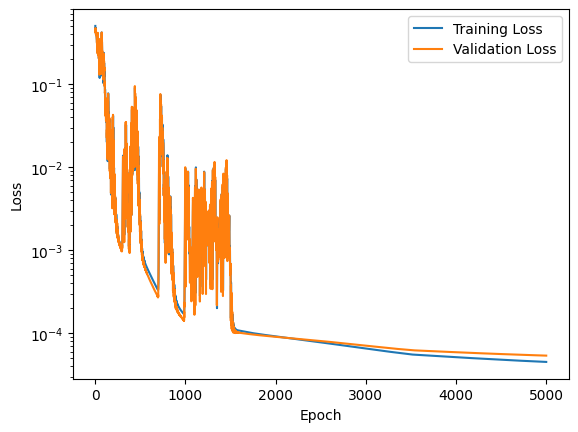

In [ ]:
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/Shivprasad/LCD_Tuned_PINN')

In [ ]:
# defining constants
tmin = 0.0 # initial time
tmax = 1 # simulate until
xmin = -1.0 # left bound
xmax = 1.0 # right bound
c = 1 # diffusion coefficient
v = 1 # velocity
pi = np.pi
n_x = 60
n_t = 10000

dt = (tmax-tmin)/n_t
dx = (xmax-xmin)/n_x
X = np.linspace(xmin,xmax,n_x+1)
T = np.linspace(tmin,tmax,n_t+1)

# Initial Condition
def u_init(x):
  return -np.sin(pi*x)
u = [u_init(m) for m in X]

# Boundary Condition
u_0 = 0 # at x = -1
u_n = 0 # at x = 1

t = tmin
u_old = u

In [ ]:
U = [u_old]
t0 = time()
while ((t+dt) <= tmax):
    u_new = [u_0]*n_x
    u_new.append(u_n)
    for i in range(1,n_x):
        u_new[i] = u_old[i] + (v*dt/(dx**2))*(u_old[i+1]+u_old[i-1]-(2*u_old[i])) - (c*dt/(2*dx))*(u_old[i+1]-u_old[i-1])
    U.append(u_new)
    u_old = u_new
    t += dt
print('Computation Time = {} seconds'.format(time()-t0))

Computation Time = 0.7060775756835938 seconds


In [ ]:
U = [u_old]
from time import time
t0 = time()
while ((t+dt) <= tmax):
    u_new = [u_0]*n_x
    u_new.append(u_n)
    for i in range(1,n_x):
        u_new[i] = u_old[i] + (v*dt/(dx**2))*(u_old[i+1]+u_old[i-1]-(2*u_old[i])) - (c*dt/(2*dx))*(u_old[i+1]-u_old[i-1])
    U.append(u_new)
    u_old = u_new
    t += dt
print('Computation Time = {} seconds'.format(time()-t0))

Computation Time = 0.6987748146057129 seconds


In [ ]:
U2 = np.array(U).T
T2, X2 = np.meshgrid(T, X)
grid = np.vstack([T2.flatten(),X2.flatten()]).T
input = tf.cast(grid,DTYPE)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/LCD_Tuned_PINN')
u_pred = model(input)
U3 = u_pred.numpy().reshape(n_x+1,n_t+1)

Glinowiecka-Cox, Małgorzata B., "Analytic Solution of 1D Diffusion-Convection Equation with Varying
Boundary Conditions" (2022). University Honors Theses. Paper 1182.

In [ ]:
# defining constants
dt = 0.001 # time increment
nx = 500 # number of position points (spatial resolution)
beta = 1 # velocity
n = 100 # number of eigenvalues

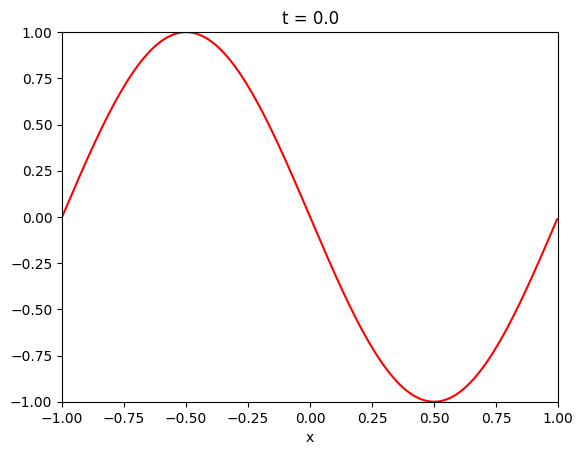

In [ ]:
# sample datapoints
x = np.arange(xmin, xmax, (xmax - xmin)/nx)

#set initial condition
def f(x):
    return -np.sin(np.pi*x/xmax)

#compute eigenvalues
a = np.empty(n)
N = np.arange(1,n+1,1)
for i in N:
    a[i-1]=(-(i*np.pi/xmax)**2)

#define solution
def u(x,t,beta):
    sum = 0
    for i in N:
        L = xmax-xmin
        sum = sum+2/L*scipy.integrate.quad(lambda x:exp(-beta/(2*c**2)*(x))*f(x)*np.sin(i*np.pi*(x+L/2)/L),xmin,xmax)[0]*np.sin(i*np.pi*(x+L/2)/L)*exp(-c**2*(i*np.pi/xmax)**2*t)
    return sum*exp(-beta**2/(4*c**2)*t)*exp(beta/(2*c**2)*x)

#producing animation
fig, ax = plt.subplots()
ax.set_xlabel('x')
plotLine, = ax.plot(x, np.zeros(len(x))*np.NaN, 'r-')
plotTitle = ax.set_title("t=0")
ax.set_ylim(-1,1)
ax.set_xlim(xmin,xmax)
def solution(t):
    p = u(x,t,beta)
    return p
def animate(t):
    pp = solution(t)
    plotLine.set_ydata(pp)
    plotTitle.set_text('t = ' + str(round(t,3)))
    return [plotLine,plotTitle]
ani = animation.FuncAnimation(fig, func=animate, frames=np.arange(tmin, tmax, dt),blit=False)
#saving animation
ani.save("Dirichlet.gif",writer=PillowWriter(fps=24))

In [ ]:
def initial(x):
    return -np.sin(np.pi*x/xmax)
def u_anal(x,t): # finite series (100 terms) approximation of the infinite series analytical solution
    sum = 0
    for i in range(1,101):
        L = xmax-xmin
        sum = sum+2/L*scipy.integrate.quad(lambda x:exp(-(x+L/2)/2)*initial(x)*np.sin(i*np.pi*(x+L/2)/L),xmin,xmax)[0]*np.sin(i*np.pi*(x+L/2)/L)*exp(-((i*np.pi/L)**2)*t)
    return sum*exp(-t/4)*exp((x+L/2)/2)

In [ ]:
u_anal(1,1)

2.415204594069241e-18

In [ ]:
L = xmax-xmin
np.sin(np.pi*(1+L/2)/L)

1.2246467991473532e-16

In [ ]:
np.sin(np.pi)

1.2246467991473532e-16

In [ ]:
import sympy as sp

In [ ]:
sp.sin(sp.pi)

0

In [ ]:
t,x = tf.cast(T2,DTYPE),tf.cast(X2,DTYPE)
u_true = u_anal(x,t)
UT = u_true

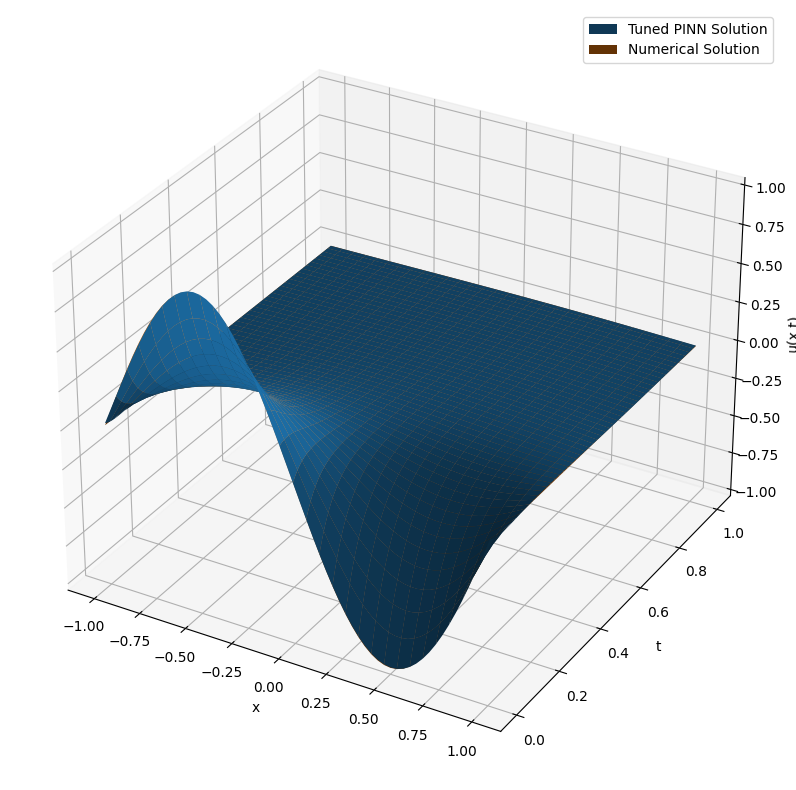

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X2, T2, U3, label = 'Tuned PINN Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X2, T2, U2, label = 'Numerical Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

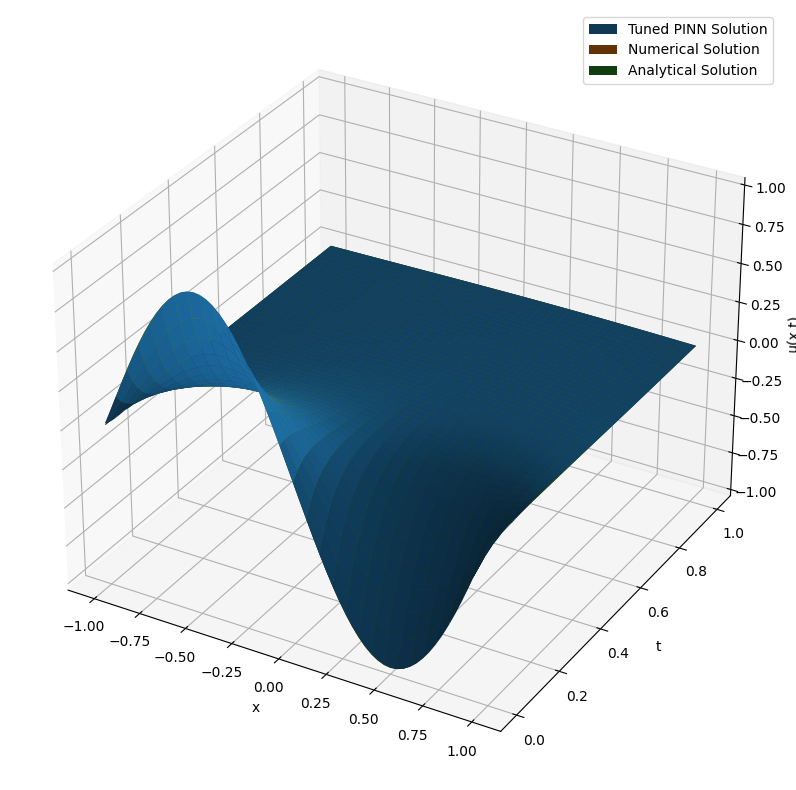

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X2, T2, U3, label = 'Tuned PINN Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X2, T2, U2, label = 'Numerical Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
c3 = ax.plot_surface(X2, T2, UT, label = 'Analytical Solution')
c3._facecolors2d = c3._facecolor3d
c3._edgecolors2d = c3._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

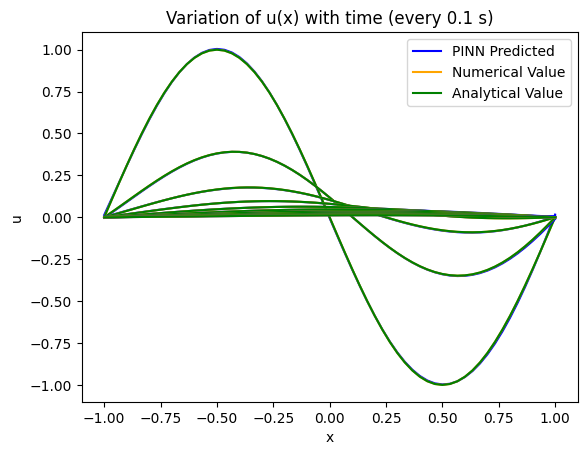

In [ ]:
from IPython import display
from time import sleep
for i in range(0,10001,1000):
    plt.plot(X,U3[:,i],color='blue')
    plt.plot(X,U2[:,i],color='orange')
    plt.plot(X,UT[:,i],color='green')
    plt.legend(['PINN Predicted','Numerical Value','Analytical Value'])
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Variation of u(x) with time (every 0.1 s)')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.5)

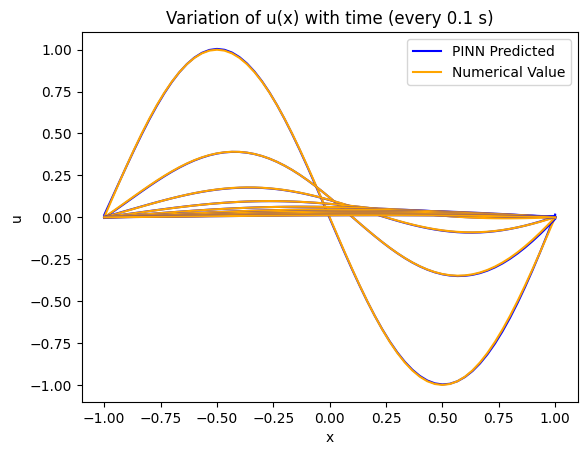

In [ ]:
from IPython import display
from time import sleep
for i in range(0,10001,1000):
    plt.plot(X,U3[:,i],color='blue')
    plt.plot(X,U2[:,i],color='orange')
    plt.legend(['PINN Predicted','Numerical Value'])
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Variation of u(x) with time (every 0.1 s)')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.5)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(U2.flatten(), U3.flatten()) # MSE between numerical solution and pinn prediction

2.204350832691673e-06

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(U2.flatten(), UT.flatten()) # MSE between analytical & numerical solution

3.4939922354609265e-09

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(UT.flatten(), U3.flatten()) # MSE between pinn prediction and analytical solution

2.2260704e-06

In [ ]:
input

<tf.Tensor: shape=(610061, 2), dtype=float32, numpy=
array([[ 0.000e+00, -1.000e+00],
       [ 1.000e-04, -1.000e+00],
       [ 2.000e-04, -1.000e+00],
       ...,
       [ 9.998e-01,  1.000e+00],
       [ 9.999e-01,  1.000e+00],
       [ 1.000e+00,  1.000e+00]], dtype=float32)>

In [ ]:
U2

array([[ 1.22464680e-16,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.04528463e-01,  1.04113525e-01,  1.03727985e-01, ...,
         3.91923485e-04,  3.91815016e-04,  3.91706578e-04],
       [ 2.07911691e-01,  2.07399945e-01,  2.06888986e-01, ...,
         7.95906873e-04,  7.95686614e-04,  7.95466418e-04],
       ...,
       [-2.07911691e-01, -2.08013410e-01, -2.08114707e-01, ...,
         1.99627726e-03,  1.99574527e-03,  1.99521341e-03],
       [-1.04528463e-01, -1.04737260e-01, -1.04917780e-01, ...,
         1.01627876e-03,  1.01600795e-03,  1.01573721e-03],
       [-1.22464680e-16,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
U3

array([[ 1.3697338e-02,  1.3583946e-02,  1.3471361e-02, ...,
         5.5199489e-05,  5.5301003e-05,  5.5440702e-05],
       [ 1.1150707e-01,  1.1127000e-01,  1.1103341e-01, ...,
         4.3046754e-04,  4.3049455e-04,  4.3026544e-04],
       [ 2.0994757e-01,  2.0958917e-01,  2.0923139e-01, ...,
         8.1820786e-04,  8.1811473e-04,  8.1793033e-04],
       ...,
       [-2.0881753e-01, -2.0874274e-01, -2.0866752e-01, ...,
         3.9037485e-03,  3.9049052e-03,  3.9064344e-03],
       [-9.8067515e-02, -9.8082162e-02, -9.8096102e-02, ...,
         3.2505095e-03,  3.2521393e-03,  3.2540429e-03],
       [ 1.6266784e-02,  1.6162863e-02,  1.6058227e-02, ...,
         2.5998279e-03,  2.6019681e-03,  2.6043747e-03]], dtype=float32)

In [ ]:
UT

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.04527481e-01,  1.04114853e-01,  1.03717595e-01, ...,
         3.91688169e-04,  3.91579757e-04,  3.91471345e-04],
       [ 2.07916826e-01,  2.07399994e-01,  2.06888378e-01, ...,
         7.95427011e-04,  7.95206870e-04,  7.94986845e-04],
       ...,
       [-2.07905427e-01, -2.08012328e-01, -2.08114311e-01, ...,
         1.99502590e-03,  1.99449412e-03,  1.99396280e-03],
       [-1.04528271e-01, -1.04735427e-01, -1.04927234e-01, ...,
         1.01563951e-03,  1.01536885e-03,  1.01509807e-03],
       [ 2.96480096e-07,  2.96002213e-07,  2.95428009e-07, ...,
        -1.72504022e-09, -1.72458048e-09, -1.72412096e-09]], dtype=float32)